# LEO Propagation Comparaison

This nootbook performs orbit propagation of LEO(Low Earth Orbit) using TLE datafeed, it compares [SGP4](http://help.agi.com/stk/index.htm#stk/vehSat_orbitProp_msgp4History.htm) legacy propagator with other solvers.

A two-line element set (TLE) is a data format encoding a list of orbital elements of an Earth-orbiting object for a given point in time, the epoch.

Orbital elements corresponds to Keplerian Elements of the object. 

![Orbital-element](400px-Orbital_elements.svg.png)


##  Requirements 

In [17]:
# Install Requirements
import sys
!{sys.executable} -m pip install pyorbital --user 
!{sys.executable} -m pip install pykep --user
!{sys.executable} -m pip install pygmo --user
!{sys.executable} -m pip install poliastro --user
!{sys.executable} -m pip install astropy --user

# 1 - Import data and visualisation 

In [2]:
# Global dependencies

import numpy as np

from astropy import units as u
from astropy.time import Time

###  Import TLE 

[Astroquery](https://astroquery.readthedocs.io) does not manage LEO databases. So, [pyorbital](https://pyorbital.readthedocs.io) makes possible loading the last ephemerides of L.E.O. 
It can either read  them from [Celestrak](http://celestrak.com) or from a designated TLE file and used a SGP4 propagator to fill ranges.
It's affilated with the [Pytroll](http://pytroll.github.io/) intiative.


In [278]:
from pyorbital.orbital import Orbital
from datetime import datetime
from dateutil import rrule

# Get TLE from Norad name
# TODO: improve library links file
#sat_name = 'JASON-1ON'
#sat_name = 'SARAL'
#sat_name = 'CryoSat-2'
#sat_name = 'NOAA 15'
#sat_name = 'ALTAIR PATHFINDER' 
#sat_name = 'ASTERIA'
sat_name = 'ISS (ZARYA)' 
retreiver = Orbital(sat_name) 
print(retreiver) # display (last) TLE 

ISS (ZARYA) {'arg_perigee': 5.4414,
 'bstar': 4.5453e-05,
 'classification': 'U',
 'element_number': 999,
 'ephemeris_type': 0,
 'epoch': numpy.datetime64('2019-09-04T17:02:57.951744'),
 'epoch_day': 247.71039296,
 'epoch_year': '19',
 'excentricity': 0.000802,
 'id_launch_number': '067',
 'id_launch_piece': 'A  ',
 'id_launch_year': '98',
 'inclination': 51.6465,
 'mean_anomaly': 144.2903,
 'mean_motion': 15.50432168,
 'mean_motion_derivative': 2.175e-05,
 'mean_motion_sec_derivative': 0.0,
 'orbit': 18759,
 'right_ascension': 326.8109,
 'satnumber': '25544'}


In [280]:
# Compute ephemerides and epoch from TLE 
epoch = retreiver.tle.epoch
r_now, v_now = retreiver.get_position(epoch, normalize = False) 
print("r (km)   : ", r_now)
print("v (km/s) : ", v_now)

r (km)   :  [-3759.07383317  4989.32976462  2674.39260098]
v (km/s) :  [-5.47345012 -1.32543116 -5.19209127]


###  Orbit visualization


[poliastro](https://docs.poliastro.space/) is not just an Astrodynamics libraries, but also comes with powerful plotting routine. 
It's affiliated with the [Astropy](https://www.astropy.org/) intiative

In [281]:
from poliastro.twobody.orbit import Orbit
from poliastro.bodies import Earth
from poliastro.plotting.static import StaticOrbitPlotter

# Define orbit from last TLE
sat_orbit = Orbit.from_vectors(Earth, r_now * u.km, v_now * u.km/u.s, Time(epoch) )
print(sat_orbit)

6787 x 6807 km x 51.7 deg (GCRS) orbit around Earth (♁) at epoch 2019-09-04T17:02:57.951744000 (UTC)


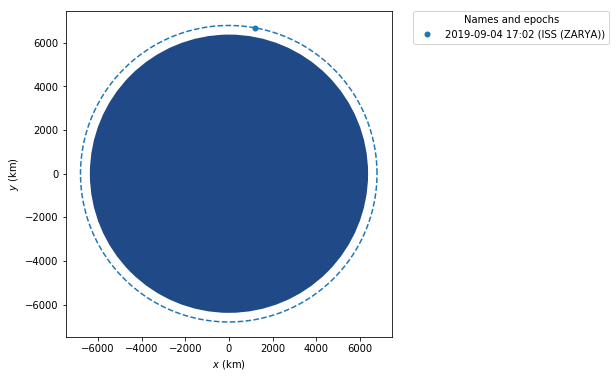

In [282]:
# Plot the orbit
plotter = StaticOrbitPlotter()
plotter.plot(sat_orbit, label = sat_name )

# 2 -  SPG4 Propagation 

In [234]:
# Generate comparaison range 
# TODO: generate range
_dtstart = datetime(year = 2019, month = 6, day = 1, hour = 12, minute = 30, second = 0)
N = 60 * 4 # 4 hours
date_range = np.asarray(list(rrule.rrule(rrule.MINUTELY , count = N, dtstart = _dtstart)))

# Retreive position and velocity using SGP4 
raw_pos, raw_vel = retreiver.get_position(date_range , normalize = False) 
r = np.asarray(raw_pos).T.reshape(N,3)
v = np.asarray(raw_vel).T.reshape(N,3)

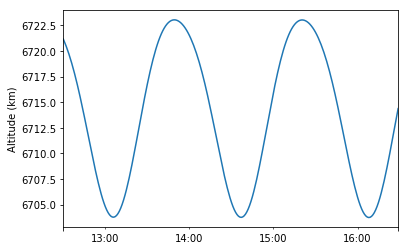

In [245]:
import matplotlib.pyplot as plt
from pandas import Series


# Plotting altitude
s_r = Series( np.linalg.norm(r, axis = 1), date_range)
ax1 = s_r.plot()
ax1.set_ylabel("Altitude (km)")
plt.show()

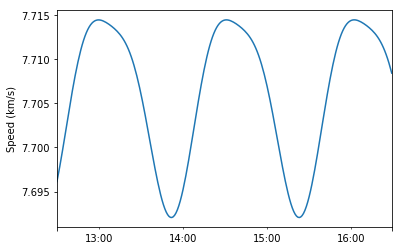

In [247]:
# Plotting speed
s_v = Series( np.linalg.norm(v, axis = 1), date_range)
ax2 = s_v.plot()
ax2.set_ylabel("Speed (km/s)")
plt.show()

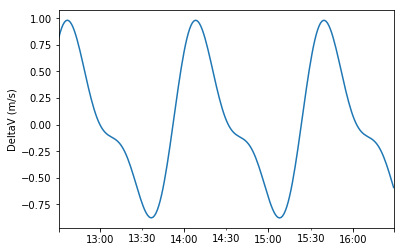

In [248]:
# Define delta v Series (https://en.wikipedia.org/wiki/Delta-v)
delta_v = np.diff(np.linalg.norm(v, axis=1), axis=0) * 1000 # in m/s
s_delta_v = Series(delta_v, date_range[1:])

# Plotting deltaV
ax3 = s_delta_v.plot()
ax3.set_ylabel("DeltaV (m/s)")
plt.show()

# 3 - Home-made Propagation

### Pertubation forces modelling 

In [283]:
#Perturbations routines

from numba import jit
from poliastro.core.util import norm
from poliastro.core.perturbations import atmospheric_drag, third_body, J2_perturbation, radiation_pressure

# Atmospherical drag using Bstar
# Ref : https://en.wikipedia.org/wiki/BSTAR
@jit
def atmospheric_drag_bis(t0, state, k, R, Bstar, H0, rho0):
    r"""Calculates atmospheric drag acceleration using Bstar (km/s2)"""

    H = norm(state[:3])
    rho_frac = np.exp(-(H - R) / H0) #Howard Curtis, section 12.4	
    v_vec = state[3:]
    v = norm(v_vec)

    return -(1.0 / 2.0) * rho_frac *  Bstar * v * v_vec

# A quick fix of third body in "perturbations.py"
@jit
def third_body_bis(t0, state, k, k_third, third_body):

    body_r = third_body
    delta_r = body_r - state[:3]
    return k_third * delta_r / norm(delta_r) ** 3 - k_third * body_r / norm(body_r) ** 3

# Combining multiple perturbation
@jit
def J2_and_third_body(t0, state, k, J2, R , k_third , third_body):
    
    return J2_perturbation(t0, state, k, J2, R) + third_body_bis(t0, state, k, k_third, third_body)

@jit
def J2_and_third_and_ad(t0, state, k, J2, R , k_third , third_body, Bstar, H0, rho0):
    return J2_perturbation(t0, state, k, J2, R) + third_body_bis(t0, state, k, k_third, third_body) +  atmospheric_drag_bis(t0, state, k, R, Bstar, H0, rho0)


### Third bodies ephemerids modelling

In [284]:
#Body position routines

from astropy.coordinates import GCRS, ICRS, CartesianRepresentation, get_body_barycentric
from scipy.interpolate import interp1d

# This is a quick fix of build_ephem_interpolant function in 'ephem.py'
def get_body_pos_from_date(body, period, date_range, delta , rtol = 1e-5):

    delta = delta.to(u.day)
    epoch = Time(date_range)
    epoch.format = 'jd'
    t_span = (epoch.value * u.day , (epoch.value + delta.value) * u.day )

    h = (period * rtol).to(u.day).value
    t_span = (t_span[0].to(u.day).value, t_span[1].to(u.day).value + 0.01)
    t_values = np.linspace(*t_span, int((t_span[1] - t_span[0]) / h))
    r_values = np.zeros((t_values.shape[0], 3))

    for i, t in enumerate(t_values):
            epoch = Time(t, format="jd", scale="tdb")
            r = get_body_barycentric(body.name, epoch)
            r = (ICRS(x=r.x, y=r.y, z=r.z, representation_type=CartesianRepresentation).transform_to(GCRS(obstime=epoch)).represent_as(CartesianRepresentation))
            r_values[i] = r.xyz.to(u.km).T[0]

    t_values = ((t_values - t_span[0]) * u.day).to(u.s).value
    
    return interp1d(t_values.reshape(-1), r_values, kind="cubic", axis=0, assume_sorted=True)

# A fix on 'perturbations.py' on third_body was needed to delete t0 call
def get_body_position(body, epoch):
    r = get_body_barycentric(body.name, epoch)
    r = (ICRS(x=r.x, y=r.y, z=r.z, representation_type=CartesianRepresentation).transform_to(GCRS(obstime=epoch)).represent_as(CartesianRepresentation))
    return r
    

### Perturbation Forces computing

In [286]:
# Compare perturbations applied on satellite

from poliastro.bodies import Sun, Moon

# Sample a value
t0 = 0
i = 100
state = np.array([r[i,0], r[i,1] , r[i,2] , v[i,0], v[i,1], v[i,2]])

# generic Param
_R = Earth.R.to(u.km).value
_k = Earth.k.value

# J2 Param
_J2 = Earth.J2.value

# Third body Moon params
body_m = Moon
k_third_m = body_m.k.to(u.km ** 3 / u.s ** 2).value
_epoch = Time(date_range[1])
r_body_m = get_body_position(body = body_m, epoch = _epoch).get_xyz().to(u.km).value

# Third body Sun params
body_s = Sun
k_third_s = body_s.k.to(u.km ** 3 / u.s ** 2).value
_epoch = Time(date_range[1])
r_body_s = get_body_position(body = body_s, epoch = _epoch).get_xyz().to(u.km).value

# Drag
_Bstar = retreiver.tle.bstar * _R # convert from tle unit
_rho0 = Earth.rho0.to(u.kg / u.km ** 3).value  # kg/km^3
_H0 = Earth.H0.to(u.km).value


# Radiation pressure
# TODO : retreive from ?
#_C_R = 1
#_A = 12
#_m = 1220
#_Wdivc_s = Sun.Wdivc.value
#_star = r_body_s

# Compute perturbations
J2_value = J2_perturbation(t0, state, _k, _J2, _R) 
third_value_m = third_body_bis(t0, state, _k, k_third_m, r_body_m)
third_value_s = third_body_bis(t0, state, _k, k_third_s, r_body_s)
ad_value = atmospheric_drag_bis(t0, state, _k, _R, _Bstar, _H0, _rho0)
#rad_value = radiation_pressure(t0, state, _k, _R, _C_R, _A, m, Wdivc_s, star)


print('J2 Pertubation   : ', norm(J2_value))
print('Moon Pertubation : ', norm(third_value_m))
print('Sun Pertubation  : ', norm(third_value_s))
print('Atm Pertubation  : ', norm(ad_value)) #TODO fix me : multiply by mass

J2 Pertubation   :  12006.194793999339
Moon Pertubation :  8.523750594439812e-10
Sun Pertubation  :  2.7861713459892274e-10
Atm Pertubation  :  3.998606573184236e-17


### Compare Own and SGP4 Propagation

In [ ]:
from astropy.coordinates import GCRS, ICRS, CartesianRepresentation, get_body_barycentric

from poliastro.twobody.propagation import cowell,kepler
from poliastro.core.perturbations import atmospheric_drag, third_body, J2_perturbation, J3_perturbation
from poliastro.bodies import Earth, Moon

import matplotlib.pyplot as plt
from pandas import Series

In [288]:
# Propagation params
p_time = [1] * u.min  #TODO : get from "Loading"

# Drag params
_R = Earth.R.to(u.km).value
_Bstar = retreiver.tle.bstar * _R # convert from tle unit
_rho0 = Earth.rho0.to(u.kg / u.km ** 3).value  # kg/km^3
_H0 = Earth.H0.to(u.km).value

# J2 and J3 params
_J2 = Earth.J2.value
_J3 = Earth.J3.value

# Moon third Body params
_body = Moon
_k_third = _body.k.to(u.km ** 3 / u.s ** 2).value,


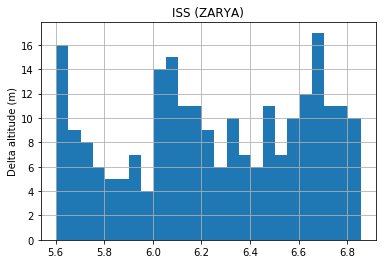

In [294]:
# Tune orbit propagation by commenting/uncommenting
p_r = []
for i in range(N-1):
    _epoch = Time(date_range[i])
    r_body = get_body_position(body = _body, epoch = _epoch).get_xyz().value 
    rr , _  = cowell(
    #rr , _ = kepler(
            Earth.k, r[i]*u.km , v[i]*u.km/u.s , p_time
            # ,ad=atmospheric_drag_bis, R = _R, rho0 = _rho0, H0 = _H0, Bstar = _Bstar
            # ,ad=J2_perturbation, R = _R , J2 =_J2 
            # ,ad=J3_perturbation, R = _R , J3 =_J3 
            # ,ad = third_body_bis, k_third = _k_third, third_body = r_body       
              ,ad = J2_and_third_body, R = _R , J2 =_J2 , k_third = _k_third, third_body = r_body
            #, ad = J2_and_third_and_ad, R = _R , J2 =_J2 , k_third = _k_third, third_body = r_body, rho0 = _rho0, H0 = _H0, Bstar = _Bstar
            )
    p_r.append(rr.value)
p_r = np.asarray(p_r).reshape(N-1, 3)

# Compute orbit residual
res_r = np.linalg.norm(r[1:N-1] - p_r[0:N-2], axis = 1) * 1000 # in meters
s_res_r = Series(res_r, date_range[1:N-1]) 

# Plotting residual
ax1 = s_res_r.hist(bins = 25)
ax1.set_title(sat_name)
ax1.set_ylabel("Delta altitude (m)")
plt.show()
